# CartPole-v0的解决：深度Q网络
深度Q网络（DQN）结合了价值函数近似和神经网络的方法，并采用目标网络和经验回放的方法进行网络的训练。相较于时序差分学习用表格存储Q函数的方法，DQN对价值函数进行近似，解决了CartPole问题中状态连续、无法用表格表示Q函数的情况，改进了传统时序差分学习。

## 算法思想
在DQN中，通过神经网络来近似表示Q函数。其输入为状态，输出为所有可能动作对应的Q值。下图阐释了Q-learning和DQN的关系：


DQN的训练过程核心思想包括：

1. 动作的选择：类似Q-learning，基于Q函数最大化的思想。
2. Q的更新：通过计算预测与目标Q值的均方误差、反向传播更新梯度的方法实现。

## 挑战：不稳定的目标
$$
\begin{equation}
Q\left(S_t, A_t\right) \leftarrow Q\left(S_t, A_t\right)+\alpha\left[R_{t+1}+\gamma \max _a Q\left(S_{t+1}, a\right)-Q\left(S_t, A_t\right)\right]
\end{equation}
$$
$$
\begin{equation}
\mathrm{Q}\left(S_t, A_t\right)=R_{t+1}+\mathrm{Q}\left(S_{t+1}, A_{t+1}\right)
\end{equation}
$$
假如采用该方法进行学习，$\mathrm{Q}\left(S_t, A_t\right)$是神经网络的预测值，$R_{t+1}+\mathrm{Q}\left(S_{t+1}, A_{t+1}\right)$是目标值，需要更新神经网络的相关参数，使得预测值和目标值尽可能地接近。然而，由于DQN改变的是对Q函数的近似表示，而非时序差分学习中Q表格的某个值，因此学习目标$R_{t+1}+\mathrm{Q}\left(S_{t+1}, A_{t+1}\right)$会随着输出的变化不断变化，导致训练不稳定的问题。同时，智能体在每次和环境交互之后都会进行优化，会导致灾难遗忘的问题。因此，为了让训练过程更加稳定、高效，引入**目标网络**、**经验回放**的思想。

### 技巧一：目标网络

可以引入一个独立于主网络的目标网络，专门用于稳定目标值的生成，二者功能分别如下：

- 目标网络用于生成目标值$R_{t+1}+\mathrm{Q}\left(S_{t+1}, A_{t+1}\right)$，使用主网络的参数进行初始化，在一段时间内保持固定，并定期使用主网络的参数更新相关参数。
- 原来的主网络用于生成预测值$\mathrm{Q}\left(S_t, A_t\right)$，根据损失函数进行主网络参数的更新，使得预测值与目标值尽可能的接近。
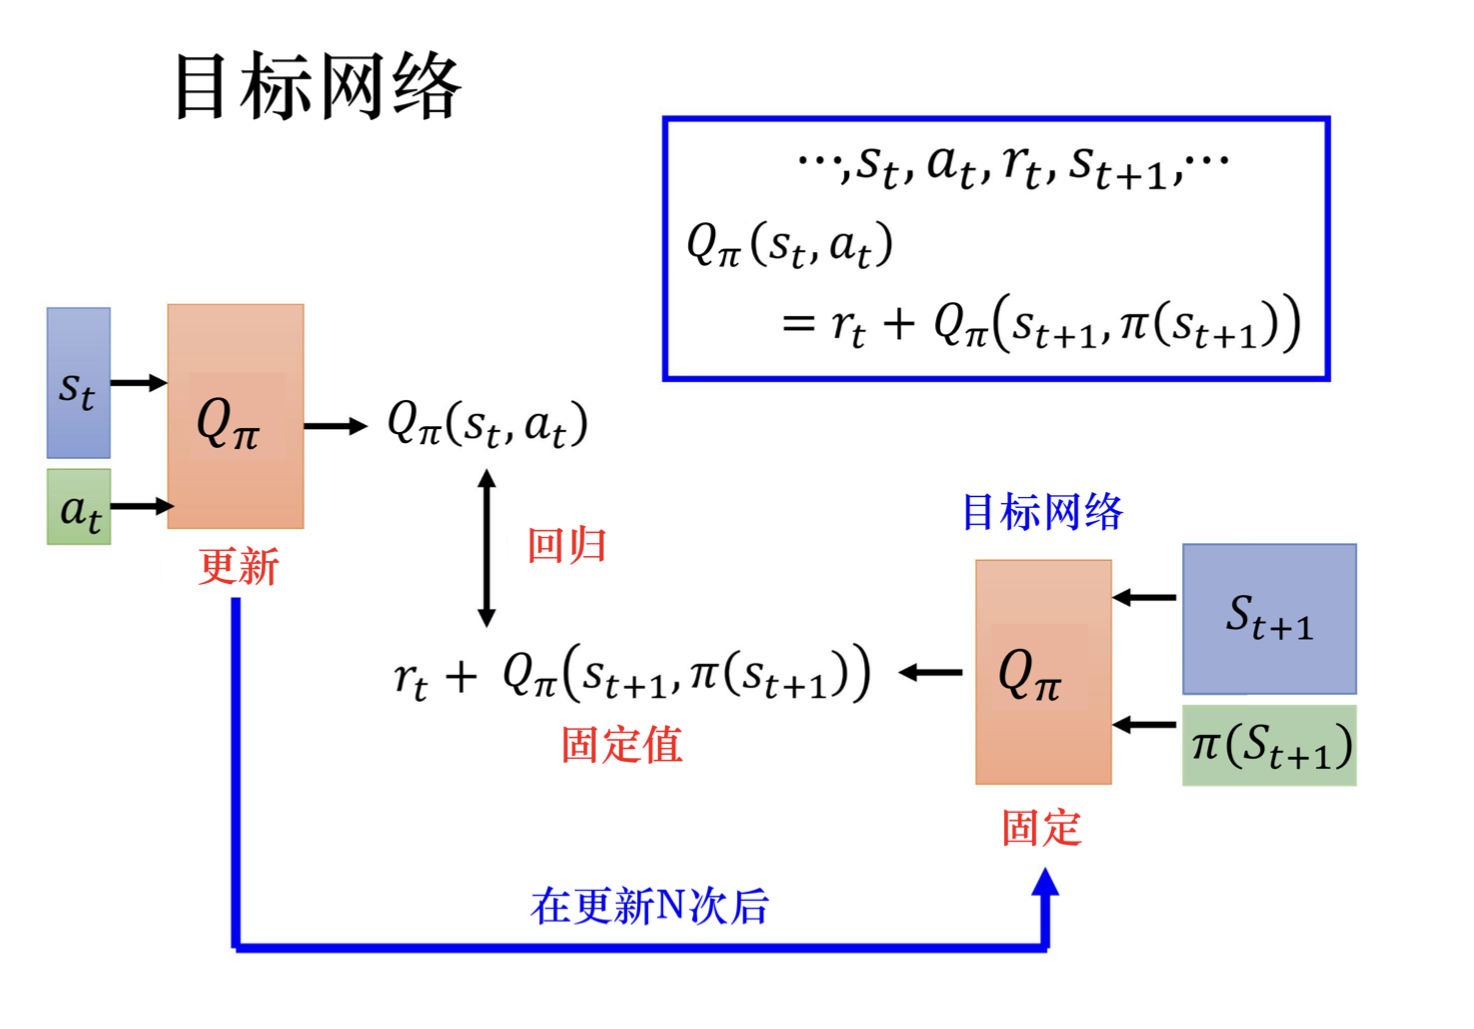

### 技巧二：经验回放

引入回放缓冲区（经验回放池），用于存储一定数量的经验信息$(S_t,A_t,R_{t+1},S_{t+1})$。

- 初始化时，随机选取策略与环境进行互动，用得到的经验将回放池填满。
- 训练时，每次从回放池随机挑选一个批量，采用对应的经验来更新Q函数，并将得到经验存入经验回访池，取代旧的经验。

采用经验回放池，一方面减少与环境的交互，可以高效地利用经验；另一方面，保证了一个批量内数据的多样性，提高训练的稳定性。

设计思想可以用下图来表示：
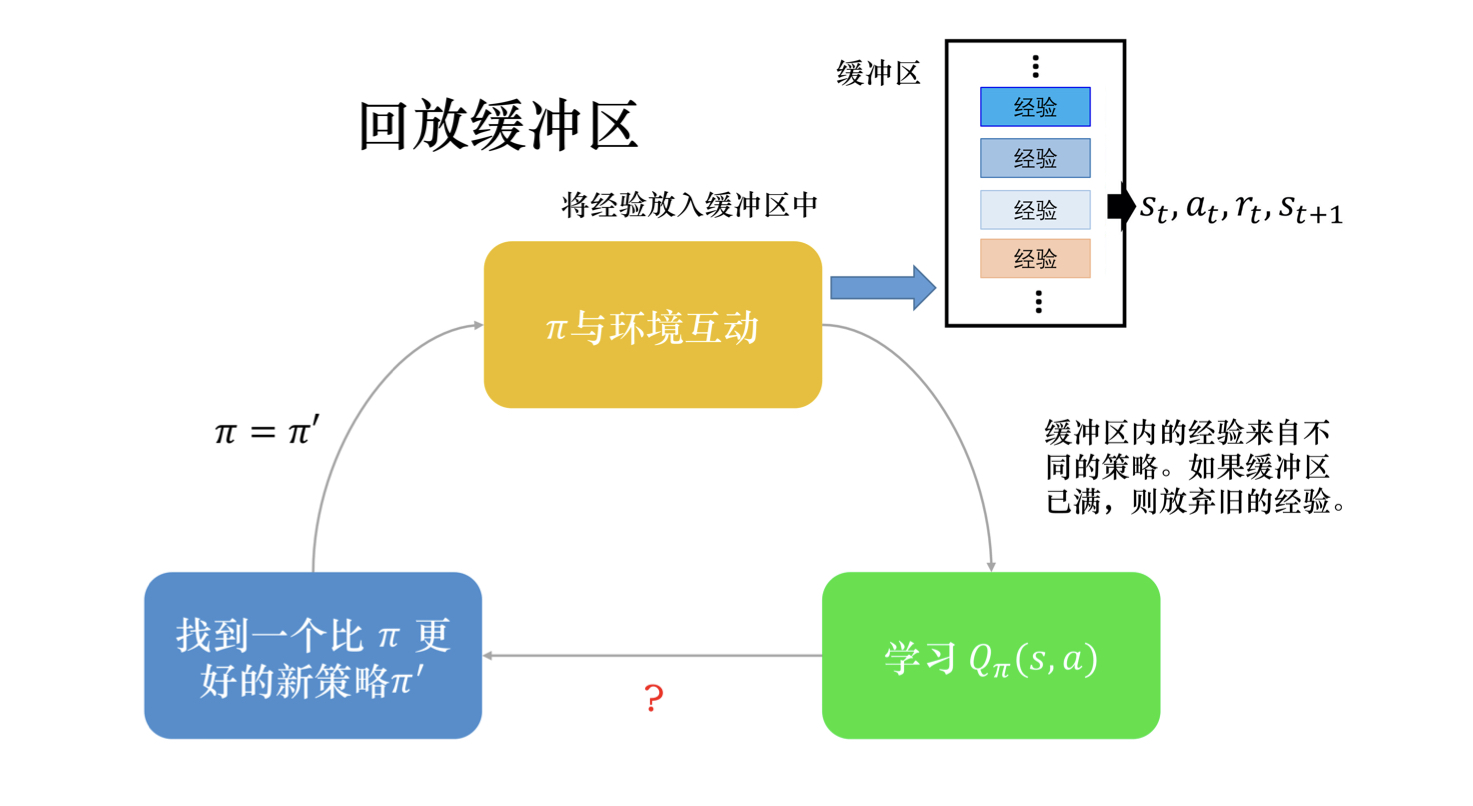

In [1]:
import torch
from torch import nn
import copy
from collections import deque
import random
import gym
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

接下来，对实现细节进行进一步阐述。网络模型`DQN`类的实现如下，其中：

- `init`：初始化

  - 初始化主网络、目标网络（采用深拷贝）
  - 定义损失函数（Mean Square Loss）、定义优化器（Adam）
  - 定义用主网络来更新目标网络的间隔次数
  - 定义超参数gamma和经验回放的最大数目

- `init_nn`：神经网络的初始化，包括

  - 输入维度为4 $(s,a,r,s')$、输出维度为64的全连接层，采用`tanh()`激活函数

  - 输入维度为64，输出维度为2$(q,a)$的全连接层，直接将结果输出

- `collect_experience`：将经验存入经验回放池
- `sample_from_experience`：用于训练时经验的随机采样
- `load_pretrained_model`：加载训练好的模型
- `save_trained_model`：保存训练好的模型
- `train`：训练过程
  - 通过主网络，得到预测Q值
  - 通过目标网络，得到目标Q值
  - 计算损失函数，通过优化器对进行参数更新
- `choose_action`：采用和解决CliffWalking问题相同的$\epsilon$-贪心法，为给定状态选择动作

In [2]:
class DQN:
    def __init__(self,seed,layer_size,lr,main2target_freq,experience_replay_size):
        '''
        DQN的初始化
        此处引入了两个技巧：
        1）主网络、目标网络的概念。在更新Q函数时，一边获取Q值一边更新Q函数，会带来不稳定问题。
           因此，引入一个目标网络，由于生成Q函数更新时的目标值。
           主网络用于Q函数值的预测，并根据损失函数进行主网络参数的更新。
           一段时间后，使用主网络的参数更新目标网络。
        2）经验回放的方法：减少跟环境做互动的次数；增强批量内的数据的多样性。
        '''
        # 设置随机数种子
        torch.manual_seed(seed);
        # 初始化主网络、目标网络
        self.Q_net = self.init_nn(layer_size)
        self.target_net = copy.deepcopy(self.Q_net) # 深拷贝，保证两个网络的参数不相互干扰
        # 定义损失函数（均方差）、定义优化器（Adam）
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.Q_net.parameters(),lr=lr)
        # 定义用主网络来更新目标网络的间隔次数
        self.main2target_freq = main2target_freq
        self.main2target_count = 0 # 距离更新的次数
        # 定义超参数gamma和经验回放的最大数目
        self.gamma = torch.tensor(0.95).float()
        self.experience_replay = deque(maxlen=experience_replay_size)

    def init_nn(self,layer_size):
        '''
        神经网络层的初始化
        采用全连接层，除最后一层外激活函数均为tanh()
        e.g. layer_size = [4, 64, 2]，则对应两层网络，分别为：
            1）输入维度为4（s、a、r、s'）、输出维度为64的全连接层，采用tanh()激活函数
            2）输入维度为64、输出维度为2（q、a）的全连接层，直接将结果输出
        '''
        layers = []
        for index in range(len(layer_size)-1):
            linear = nn.Linear(layer_size[index],layer_size[index+1])
            activation = nn.Tanh() if index < len(layer_size)-2 else nn.Identity()
            layers += (linear, activation)
        return nn.Sequential(*layers)
        
    def collect_experience(self, experience):
        # 将经验存储起来，方便经验回放
        self.experience_replay.append(experience)
    
    def sample_from_experience(self, sample_size):
        # 从经验中随机采样，得到(s,a,rn,sn)四元组
        if len(self.experience_replay) < sample_size:
            sample_size = len(self.experience_replay)
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()
        return s, a, rn, sn

    def load_pretrained_model(self,path):
        # 加载训练好的模型
        self.Q_net.load_state_dict(torch.load(path))

    def save_trained_model(self,path):
        # 保存训练好的模型
        torch.save(self.Q_net.state_dict(),path)

    def train(self, batch_size):
        s, a, rn, sn = self.sample_from_experience(sample_size=batch_size)
        # 达到间隔，将主网络的参数值赋给目标网络
        if self.main2target_count == self.main2target_freq:
            self.target_net.load_state_dict(self.Q_net.state_dict())
            self.main2target_count = 0
        # 通过主网络，得到预测Q值
        qp = self.Q_net(s)
        q_predict, _ = torch.max(qp,axis=1)
        # 通过目标网络，得到目标Q值
        with torch.no_grad():
            qn = self.target_net(sn)
        q_next, _ =torch.max(qn,axis=1)
        q_target = rn + self.gamma * q_next
        # 计算损失函数，通过优化器对进行参数更新
        loss = self.loss(q_predict,q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        self.main2target_count += 1
        return loss.item()
    
    def choose_action(self,state,action_num,epsilon):
        '''
        采用epsilon-greedy法，为给定状态选择动作
        如果概率大于epsilon，则贪心地选择使得Q最优的动作——exploitation
        如果概率小于等于epsilon，则随机选取一个动作——exploration
        '''
        with torch.no_grad(): # 用于推断，不需要更新梯度
            qp = self.Q_net(torch.from_numpy(state).float())
        q,a = torch.max(qp,axis=0)
        a = a if torch.rand(1,).item() > epsilon else torch.randint(0,action_num,(1,)) 
        return a

In [3]:
# 创建环境
env = gym.make('CartPole-v0') 

# 设置超参数，初始化模型
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
experience_replay_size = 256
episodes = 10000
epsilon = 1
agent = DQN(seed=1423, layer_size=[input_dim, 64, output_dim], lr=1e-3, main2target_freq=5, experience_replay_size=experience_replay_size)
loss_list, reward_list, len_per_episode_list, epsilon_list,episode_list = [], [], [], [], []

In [4]:
# 初始化经验回放
index = 0
for i in range(experience_replay_size):
    '''
    采用如下方法，对经验回放池进行初始化（将其填满）：
    对于一个状态obs_cur，随机选择策略a，得到下一状态obs_next和对应的reward。
    将得到[obs_cur,a,reward,obs_next]经验四元组存入经验回放池。
    '''
    obs_cur = env.reset()
    done = False
    while not done:
        a = agent.choose_action(obs_cur, env.action_space.n, epsilon=1) # 策略
        obs_next, reward, done, _ = env.step(a.item()) # 选取该策略后，从环境中得到的下一状态和对应回报
        agent.collect_experience([obs_cur,a.item(),reward,obs_next]) # 将信息存入经验回放池

        obs = obs_next # 更新状态
        index += 1
        if index > experience_replay_size: #经验回放池填满，初始化完毕
            break

In [5]:
index = 128
for i in tqdm(range(episodes)):
    obs_cur, done, loss_tot, len_per_episode, reward_tot = env.reset(), False, 0, 0, 0 # 重新初始化
    while not done:
        len_per_episode += 1
        a = agent.choose_action(obs_cur, env.action_space.n, epsilon) # 策略
        obs_next, reward, done, _ = env.step(a.item()) # 下一状态和回报
        agent.collect_experience([obs_cur, a.item(), reward, obs_next]) # 经验回放

        obs_cur = obs_next
        reward_tot += reward
        index += 1

        # 每收集128条经验，进行4次训练，每个batch大小为16
        if index > 128:
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                loss_tot += loss

    # 控制exploration和exploitation，使得epsilon由1缓慢降至0.05
    if epsilon > 0.05:
        epsilon -= (1 / 5000)
    
    if i % 50 == 0:
        loss_list.append(loss_tot / len_per_episode)
        reward_list.append(reward_tot)
        len_per_episode_list.append(len_per_episode)
        epsilon_list.append(epsilon)
        episode_list.append(i)
# 存储模型参数
print("正在存储模型参数")
agent.save_trained_model("cartpole-dqn.pth")

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\Lenovo\AppData\Local\Temp/ipykernel_33564/1530581277.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  s = torch.tensor([exp[0] for exp in sample]).float()
100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:42<00:00, 44.84it/s]

正在存储模型参数


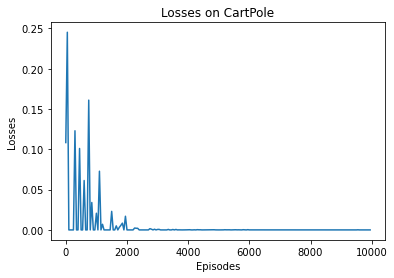

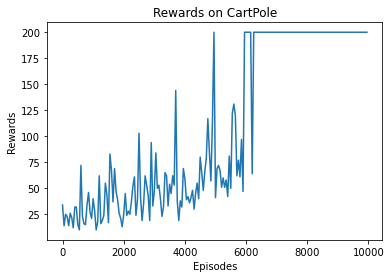

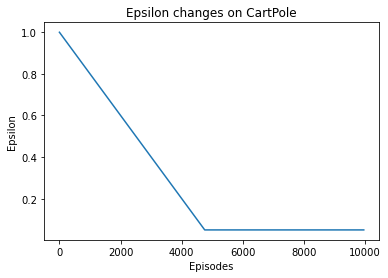

In [6]:
plt.plot(episode_list, loss_list)
plt.xlabel('Episodes')
plt.ylabel('Losses')
plt.title('Losses on CartPole')
plt.show()

plt.plot(episode_list, reward_list)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards on CartPole')
plt.show()

plt.plot(episode_list, epsilon_list)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon changes on CartPole')
plt.show()

In [8]:
reward_list = []
for i in tqdm(range(1000)):
    obs, done, reward_tot = env.reset(), False, 0
    while not done:
        a = agent.choose_action(obs, env.action_space.n, epsilon=0)
        obs, reward, done, _ = env.step(a.item())
        reward_tot += reward
        #sleep(0.01)
        #env.render()
    reward_list.append(reward_tot)
print("平均收益:", sum(reward_list) / len(reward_list))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.59it/s]

平均收益: 200.0
